In [1]:
#Import file
import InsuranceLoss
%matplotlib inline

c:\Users\bre49523\AppData\Local\Continuum\Anaconda3\envs\python2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\Users\bre49523\AppData\Local\Continuum\Anaconda3\envs\python2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Business Understanding

This kaggle competition was set up by All-State to improve their estimates of insurance loss. The Insurance Industry depends on reliable estimates of the expected value of a given policy, taking into account the expected loss to be paid out, the distribution of losses, and the timing of the loss. Insurers have developed incredibly sophisticated actuarial models for this purpose. In the case of life insurance, these models are so reliable that the Insurer can sell policies at negative expected value and still make money through interest bearing accounts.

All-State, however is a personal line insurer focusing on home and automotive. Compared to life insurance, auto-insurance payouts are less predicatable in terms of hte timing, loss amount, and payout probability, and so car-insurance is less of a 'solved' problem than life insurance. All-State is asking contestants to predict the size of insurance loss. Since the prize for the contest was employment rather than cash, and the contestents lack all the data and decades of experience that Allstate's acturaies have, it is likely that the company does not expect contestants to actually improve upon their models. This seems especially likely given that any identifying information is scrubbed from the data set, rendering this a pure machine-learning exercise.

# Data Understanding

The data has been stripped of all identifiying information so that no previous intuitions about insurance or driving will be applicable. There are 116 features with categorical data, where each category is indicated by a letter.72 of these categorical features are binary, with only 'A' and 'B' as values, while the rest have between 3 and 349 categories.

There are also 14 continuous variables.These factors come scaled between 0 and 1 and have a variety of distributions, few of them are normally distributed.


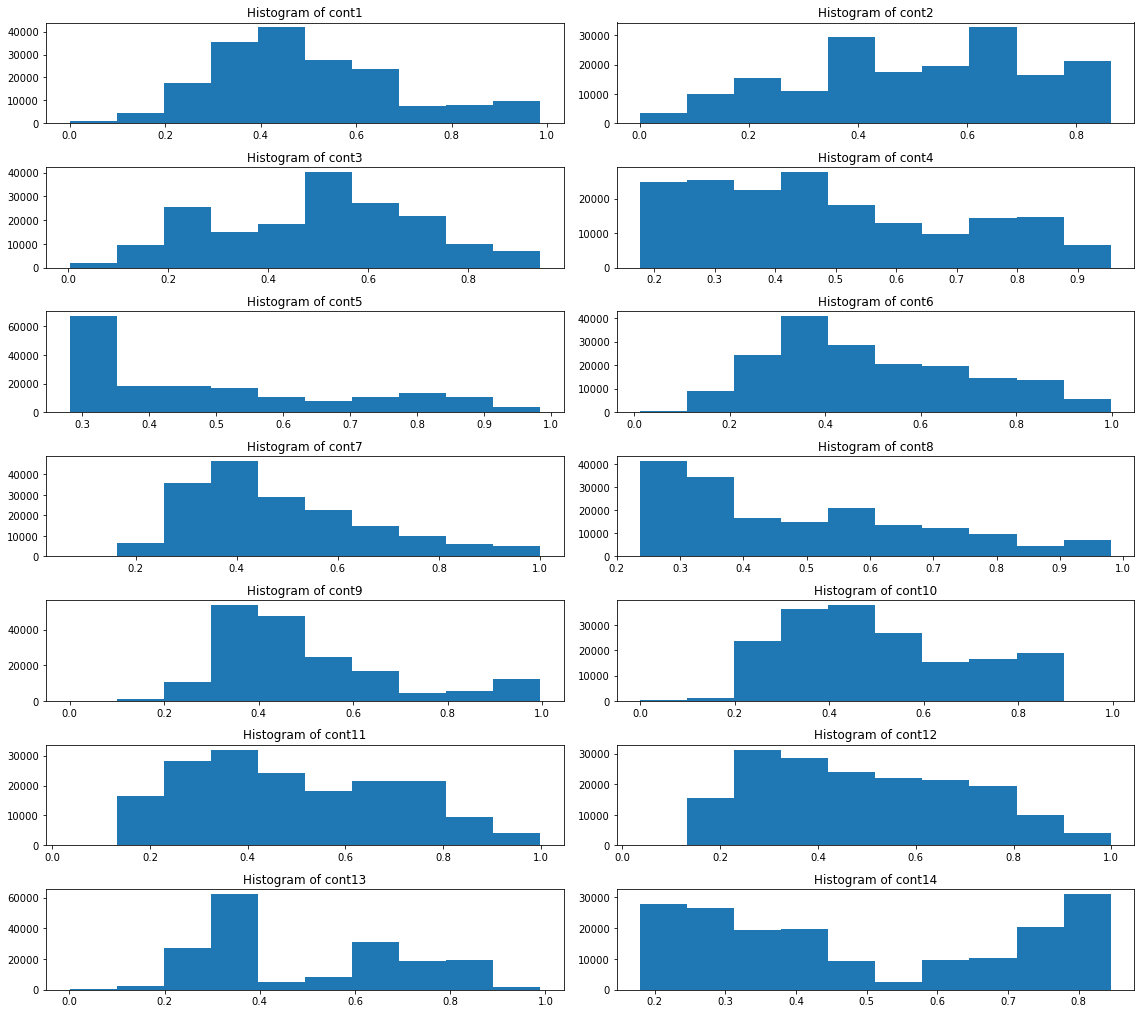

In [2]:
InsuranceLoss.continuous_hist()


### Insurance Loss

Insurance loss, the y variable, is the only variable that can be interpreted. It is presumably, the amount, in dollars, that the policy paid out the holder. All values are above zero. Since most insurance policies never pay out, this implies that the datasets only includs a small subset of all policies-those that involved some amount of loss for the company.

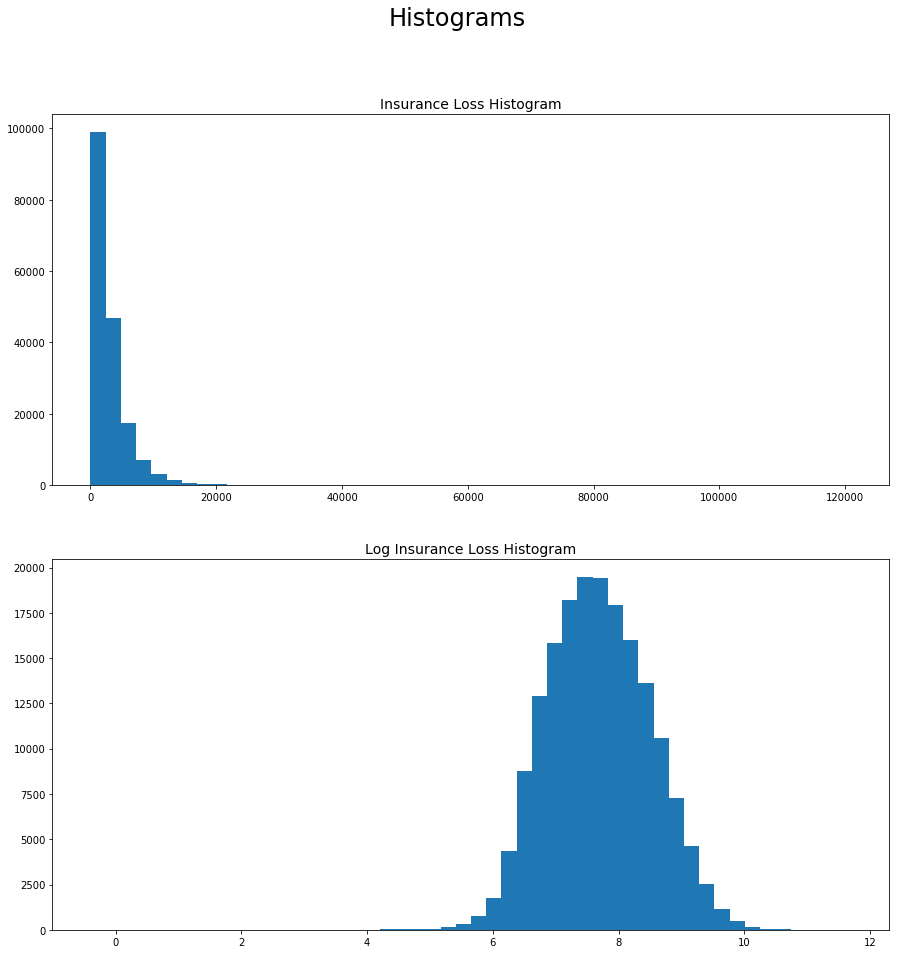

In [3]:
#histogram or density of insurance loss
InsuranceLoss.plot_loss()

The data is heavily skewed to the right. In the training set, the mean is 3,037 and the the standard deviation is only a bit smaller at 2,900. The median is 2,115 and the 7th percentile is only a bit more than the mean, at 3,864. The max, by contrast, is 121,013. This presents the challenge of a data set that is clustered close to zero, but with a few large outliers. The natural logs of hte insurance loss values is normal but still has a slight rightward skew.

When mapping the the continuous variables to the insurance loss in a scatterplot, it is clear that some of the 'continuous' features are truly continuous. But discrete features, such as years of education still act like continuous variables . the relationship between these features and the insurance loss does not look linear, and most data points are distributed towards zero. By contrast, the features mapped to the log of insurance loss looks closer  to linear, but relationships look flat.

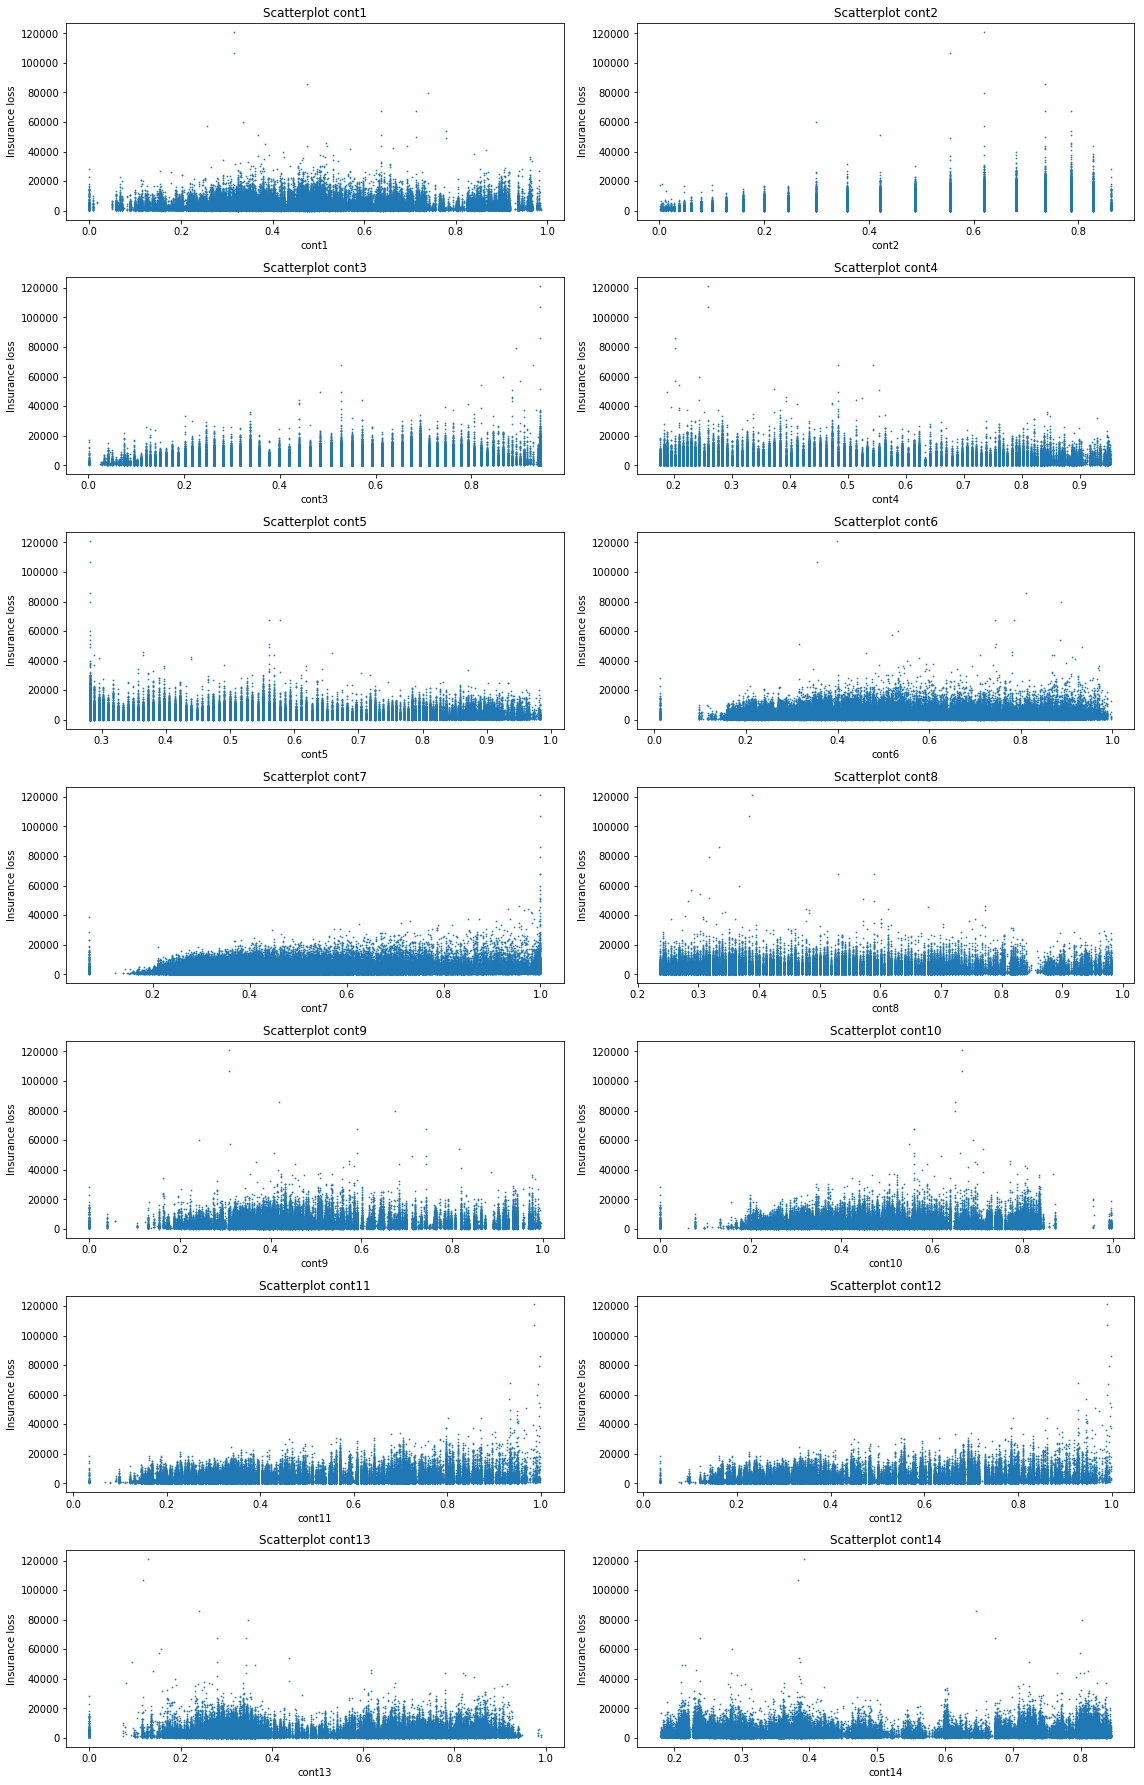

In [4]:
InsuranceLoss.continuous_scatter()

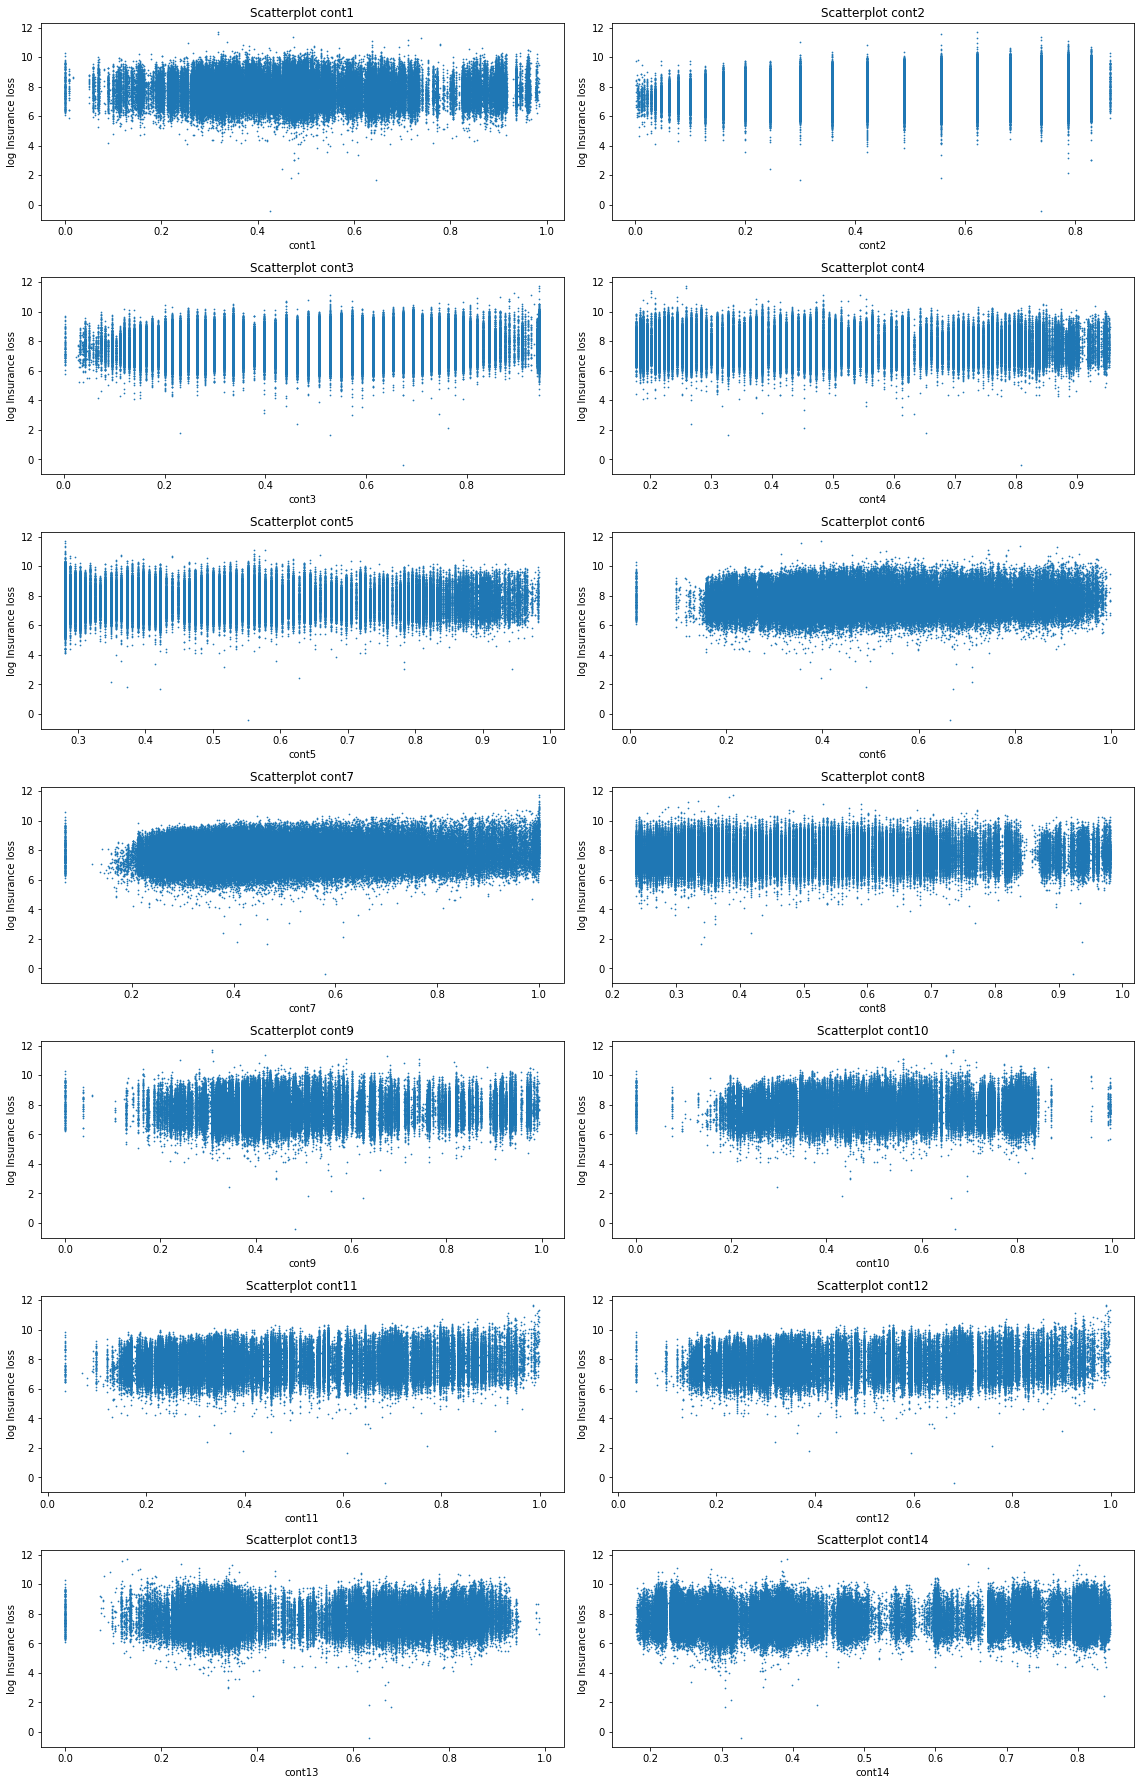

In [5]:
InsuranceLoss.continuous_scatter_log()

### Baseline linear regression

I ran a basic linear regression on the continuous features to establish a baseline. With this simpkle approach, I seem to have placed solidly in the bottom 5% of the leaderboard. The $r^{2}$ for this model was just $.03$. With 14 variables, there did not seem to be any overfitting when plotting $r^{2}$ on a dev set.

Overall, the data was highly heteroskedastic, but not otherwise obviously nonlinear.

Train R-squared: 0.0398
dev R-squared: 0.0407


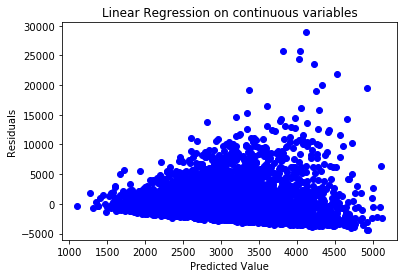

In [6]:

InsuranceLoss.base_linear()

Train R-squared: 0.0233
dev R-squared: 0.0229


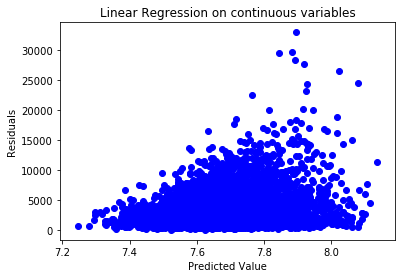

In [7]:
InsuranceLoss.base_linear_log()

The suprisingly, log model actually ended up with lower $r^2$.

I maped the score of a model against the number of features selected against $r^2$ on the development set, and then again, but with principle components. I did not find any evidenc of overfitting, even if the last few components/featurs add little to the model.

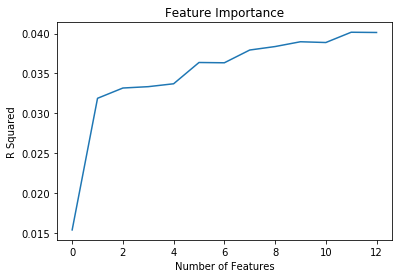

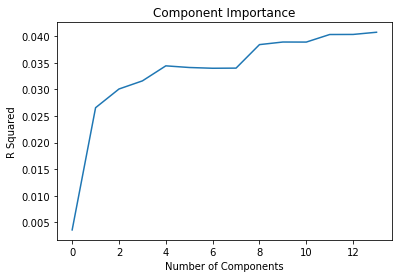

In [8]:
InsuranceLoss.best_features_linear_base()
InsuranceLoss.best_components_linear_model()

# Data Preparation

I converted the categorical data to dummy variables. I could have use a One Hot Encoder to choose one category in each categorical feature to be $1$ and the rest $0$, but opted to do a full dummy conversion instead. So a feature with n categories get converted into n-1 dummy variables.  I did thi with the therory that I didn't want to lose data or variance, and I could always remove features later. I ended up with more than a thousand total features this way.

I used a Pca to reduce the dimension of the dataset. While there is dispute over whether it's valid to combine binary and continuous features this way, or whether or not it's even ok to use pca on binary features, but the process did seem to get results for me, even if the dimensional reduction wasn't as dramatic as I'd have liked. I ended up using 400 components for my linear model.

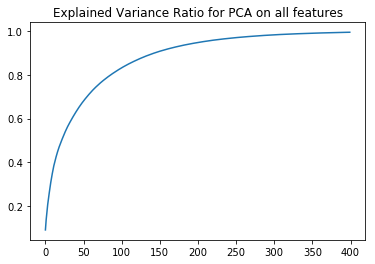

In [9]:
# show explained variance ratio for pca
InsuranceLoss.print_cum_var_ratio()

# Modelling

I attempted a number of models. For a better baseline, I attempted a linear regression on all of the features. This turned out to be badly overfit, with a $r^2$ on the dev set on the order of $-3.18e^{15}$. Using Principle Component Analysis and Feature Selection fixed the overfitting problem.

I also attempted to add polynomial features, but this was impractical on anything but just the 14 continuous variables.

Next I tried a Support Vector Machine Regression, but even limiting myself to just the 14 continuous features, it took an impractical amount of time to compute.

My original plan was to first classify the data into 'chunks' and then regress within those chunks. E.g. In my first attempt, I split the insurance loss along the 75th percentile. I would try to fit model to predict whether the cost was above or below that threshold, and then fit a seperate regression on both slices of the data.

This ran into several problems. The first was that I had trouble predicting whether loss would be above or below the 75th percentile. K Nearest Neighbors, Bernoulli Naive Bayes, and Logistic regression all had mean accuracy scores from .84 to 8.7, which was not too impressive given that a flat could get an accuracy score of 75%, and f1_scores in the 60s.

The second problem was that even when I 'cheated' and froced the test and dev data to the right categories, the regression on the split data set actually had a lower $r^2$ than a simple regression on the whole data set.

I found that reducing the 1014 features to 400 components worked

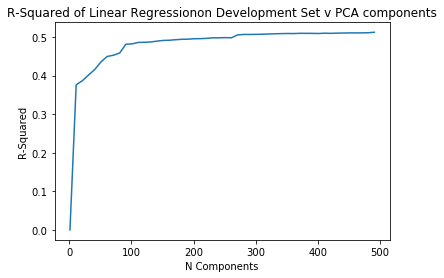

In [10]:
InsuranceLoss.fast_best_components()

# Evaluation

Train R-squared: 0.518
Development set R-squared: 0.505


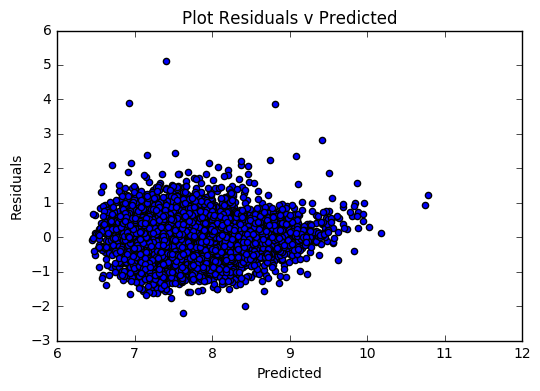

In [2]:
InsuranceLoss.large_linear_plot()

In the end, my best model was a pca reduction followed by a linear regression fited to the natural log of the insurance loss, which I had intended to be merely a 'baseline' model. The $r^2$ was around .5-.515, depending on the development set I was using. This was a dramatic improvement in absolute terms, but good for only 2300 out of 3000 on the leaderboard. I got similar, but slightly worse results with a Random Forest Regressor, and by tweaking the 

It seems my main mistake was splitting the categorical variables into so many dummy variables. It seemed to make the linear regression better, but also made other, non-linear methods impractical.

From a business perspective, the model had trouble predicting outliers, which is likely one of the insurance companies main concerns.